In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
import seaborn as sns

In [6]:
DATA_DIR = Path('.').absolute().parent / 'raw_data'
data_filename: str = 'onlinefraud.csv'
loaded_data_frame = 'dataset.pickle'

if Path(DATA_DIR / loaded_data_frame).exists():
    print("⏳ Load dataset from pickle")
    data = pd.read_pickle(DATA_DIR / loaded_data_frame)
    print("✅ Data loaded")
else:
    print("⏳ Loading dataset from csv")
    data = pd.read_csv(f"{DATA_DIR}/{data_filename}")
    print("✅ Data loaded")
    
    print("⏳ Saving dataset to pickle file")
    data.to_pickle(DATA_DIR / 'dataset.pickle')
    print("✅ Data Saved")

⏳ Load dataset from pickle
✅ Data loaded


In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.shape

(6362620, 11)

**Description of transaction types**

CASH_OUT: Withdrawal of funds from an account in the form of physical cash.

PAYMENT: Act of transferring funds from one party to another in exchange for goods or services via cash, cheques, credit cards.

CASH_IN: Depositing physical cash into an account.

TRANSFER: Moving funds from one account to another.

DEBIT: Transaction where funds are deducted from an account through a debit card transaction.

In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
#Dropping the 'isFlaggedFraud' feature. Not required as we have 'isFraud' feature to predict fraudulous transactions
data.drop('isFlaggedFraud', axis=1, inplace=True)

In [8]:
#Statistics of dataset
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [9]:
#How many records are there for each transaction type?
data.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [10]:
# Percentage
data.type.value_counts(normalize=True)

type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: float64

In [12]:
data['nameOrig'].unique().size

6353307

In [20]:
data.groupby(by=['nameOrig'])['isFraud'].sum().sort_values(ascending=False)

nameOrig
C1998644906    1
C43271707      1
C2052061131    1
C1521962059    1
C853796614     1
              ..
C164527924     0
C16452791      0
C164527901     0
C164527882     0
C999999784     0
Name: isFraud, Length: 6353307, dtype: int64

In [21]:
data.groupby(by=['nameDest'])['isFraud'].sum().sort_values(ascending=False)

nameDest
C1366192319    2
C1460854172    2
C1193568854    2
C650699445     2
C505532836     2
              ..
M1306254708    0
M1306255313    0
M1306255439    0
M1306255621    0
M999999784     0
Name: isFraud, Length: 2722362, dtype: int64

In [22]:
data.groupby(by=['nameOrig', 'nameDest'])['isFraud'].sum().sort_values(ascending=False)

nameOrig     nameDest   
C344825727   C997289329     1
C1184786020  C1519560642    1
C193359947   C1492417626    1
C1503196403  C448117484     1
C1558861751  C939990653     1
                           ..
C1645281020  C1360422976    0
C1645281014  M670437393     0
C1645280609  C1548802752    0
C1645279448  C1890730800    0
C999999784   C1952034932    0
Name: isFraud, Length: 6362620, dtype: int64

In [23]:
data.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [25]:
data.isFraud.value_counts(normalize=True) * 100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

<Axes: xlabel='isFraud'>

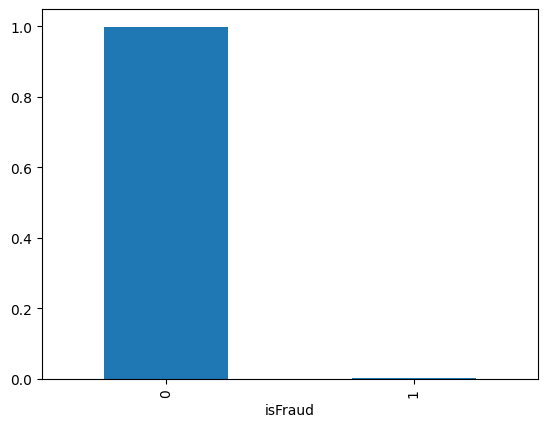

In [28]:
# Plot number of fraud entries
data.isFraud.value_counts(normalize=True).plot(kind='bar')

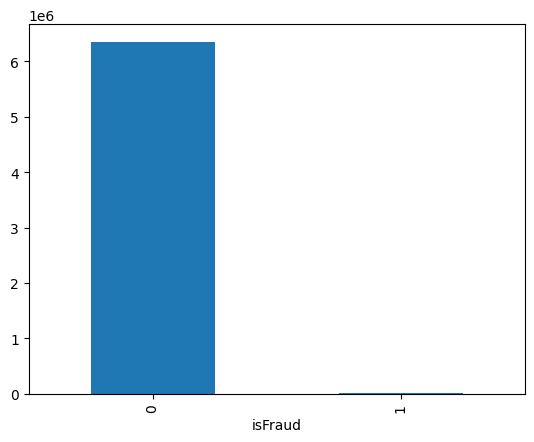

In [30]:
# Plot numbers of isFraud entries by nameDest
data.groupby('isFraud')['nameDest'].count().plot(kind='bar')
plt.show()

In [47]:
# Plot numbers of isFraud entries by nameDest
fraud_data_more_than_1 =  data[data['isFraud'] == 1][['nameDest', 'isFraud']]\
.groupby('nameDest')\
.count()\
.sort_values(by='isFraud', ascending=False)

In [59]:
fraud_data_more_than_1.size

8169

In [58]:
fraud_data_more_than_1[fraud_data_more_than_1['isFraud'] > 1].size

44

In [60]:
(44 / 8169) * 100

0.538621618313135

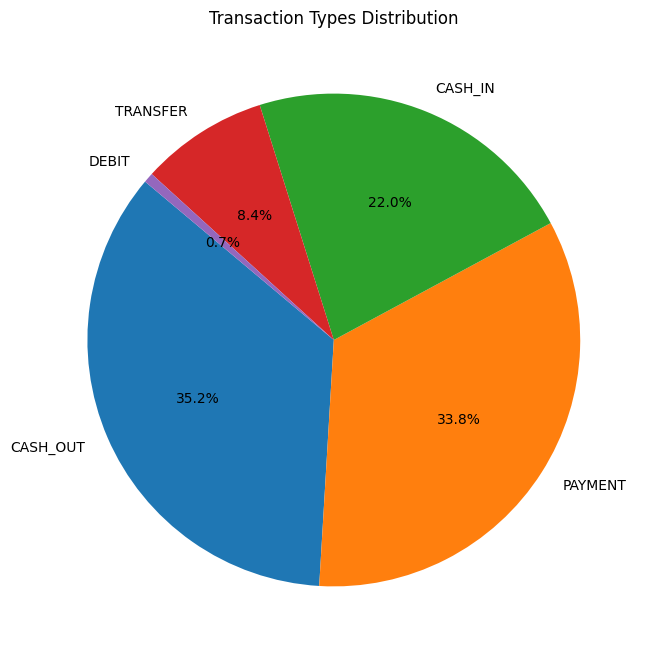

In [61]:
plt.figure(figsize=(8, 8))
type_counts=data.type.value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Transaction Types Distribution')
plt.show()

35.2% of transaction types are Cash out and 33.8% are Payment

/var/folders/46/yy2622n97qg2hyp5b8v44khr0000gp/T/ipykernel_21367/452186433.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  transaction_type=pd.value_counts(data['type'],sort = True)


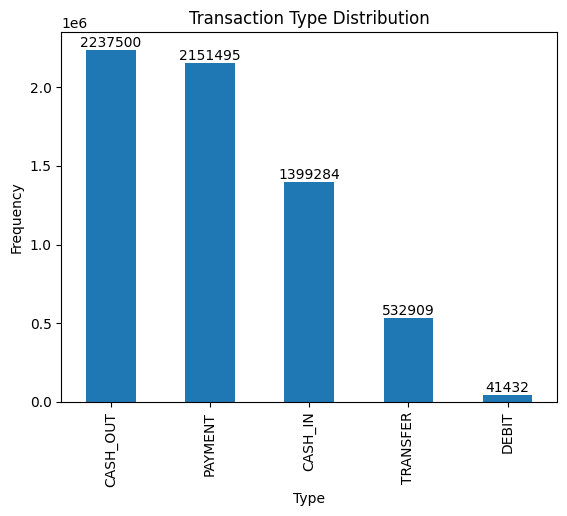

In [62]:
transaction_type=pd.value_counts(data['type'],sort = True)
number_of_transactions=transaction_type.plot(kind='bar')
plt.title('Transaction Type Distribution')
plt.xlabel('Type')
plt.ylabel('Frequency')
for i, count in enumerate(transaction_type):
    number_of_transactions.text(i, count + 0.05, str(count), ha='center', va='bottom')

In [63]:
# Correlation
numeric_data = data.select_dtypes(include=['number'])
numeric_data.corr()['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

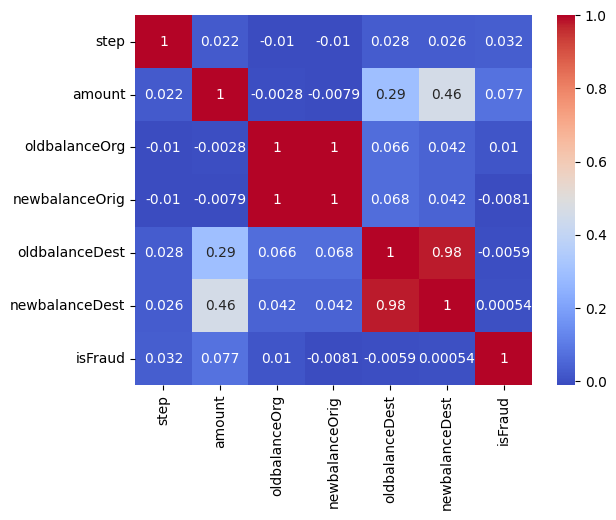

In [64]:
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.show()

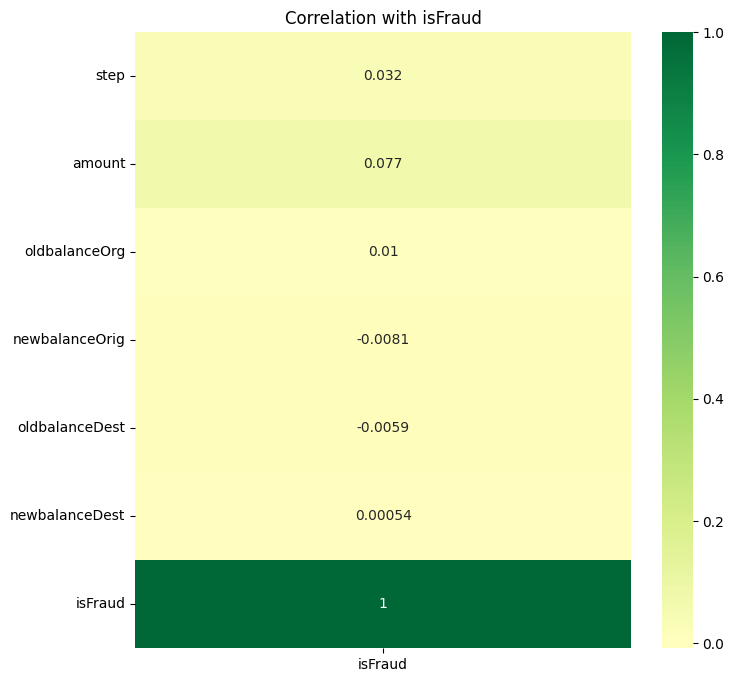

In [65]:
# Correlation with isFraud
corr = numeric_data.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr[['isFraud']], annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation with isFraud')
plt.show()

In [66]:
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1


In [67]:
X = data.drop(columns=['step', 'nameOrig', 'nameDest', 'isFraud'])
y = data['isFraud']

In [68]:
# Data splitting (Train = 0.8, test = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 6), (1272524, 6), (5090096,), (1272524,))

In [69]:
# Encoding dataset
category_transformer = OneHotEncoder(drop='if_binary')
# numeric_transformer = make_pipeline(StandardScaler())

In [70]:
# Prepross pipline
preproc = make_column_transformer(
	(category_transformer, make_column_selector(dtype_include=[object, bool])),
	# (numeric_transformer, make_column_selector(dtype_exclude=[object, bool])),
	remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17f4ae830>)])

In [74]:
# Define model
model = LogisticRegression(max_iter=1000)

In [75]:
# Define final pipline
pipline = make_pipeline(preproc, model)
pipline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f4ae830>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [76]:
pipline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f4ae830>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [81]:
pipline.score(X_test, y_test) * 100

99.9233806199333

### Test model

In [96]:
data_test = pd.DataFrame([{'type':'PAYMENT',
                          'amount': 1000.0,
                          'oldbalanceOrg': 4000.00,
                          'newbalanceOrig': 2000.00,
                          'oldbalanceDest': 100.00,
                          'newbalanceDest': 200.00}])
data_test

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,PAYMENT,1000.0,4000.0,2000.0,100.0,200.0


In [97]:
pipline.predict(data_test)

array([0])